In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [165]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter=",")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


xdataset, ydataset = readucr("numbersSoftMediumHard.csv")

xdataset = np.array([x[:4836] for x in xdataset])

print(len(xdataset))


72


# 0 is soft and 1 is medium and 2 is hard data length is 4832

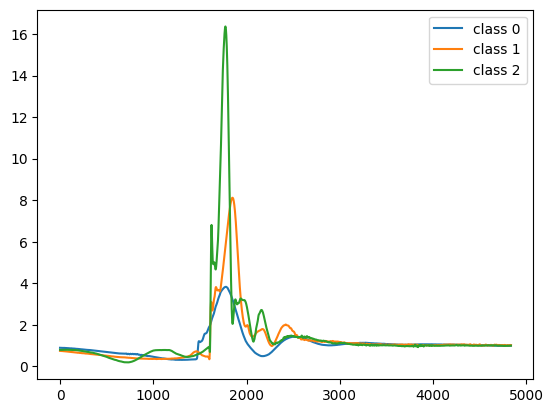

In [167]:
#plot the first of each class
plt.plot(xdataset[ydataset == 0][0], label="class 0")
plt.plot(xdataset[ydataset == 1][0], label="class 1")
plt.plot(xdataset[ydataset == 2][0], label="class 2")
plt.legend(loc="best")
plt.show()

In [216]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors (using your new X, y with length=500)
X_tensor = torch.FloatTensor(xdataset).unsqueeze(1)  # Shape: [num_samples, 1, 500]
y_tensor = torch.LongTensor(ydataset)

# Split into train/test (80/20)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders with larger batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [217]:
# 1D CNN model for 500-length sequences
class Simple1DCNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # First block
            nn.Conv1d(1, 32, kernel_size=15, padding=7),  # Preserve length (200)
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 4836 -> 2418
            
            # Second block
            nn.Conv1d(32, 64, kernel_size=7, padding=3),  # Preserve length (100)
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # 2418 -> 1209

        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 1209, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 3)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = Simple1DCNN1()
print(model)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTotal trainable parameters: {total_params:,}")

# Improved training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

Simple1DCNN1(
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(15,), stride=(1,), padding=(7,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=77376, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=3, bias=True)
  )
)

Total trainable parameters: 9,919,747


In [226]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    
    train_acc = 100 * correct / total
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}%')

Epoch 1, Loss: 0.0028, Acc: 100.00%
Epoch 2, Loss: 0.0021, Acc: 100.00%
Epoch 3, Loss: 0.0038, Acc: 100.00%
Epoch 4, Loss: 0.0036, Acc: 100.00%
Epoch 5, Loss: 0.0035, Acc: 100.00%
Epoch 6, Loss: 0.0028, Acc: 100.00%
Epoch 7, Loss: 0.0011, Acc: 100.00%
Epoch 8, Loss: 0.0021, Acc: 100.00%
Epoch 9, Loss: 0.0038, Acc: 100.00%
Epoch 10, Loss: 0.0011, Acc: 100.00%


In [228]:
total = 0
correct = 0

model.eval()

for batch in test_loader:
    # Explicitly unpack data and labels (handles both tuple and tensor cases)
    datas, labels = batch  
    print(labels)
    
    # Convert labels to tensor if they aren't already
    if isinstance(labels, tuple):
        labels = labels.float().unsqueeze(1)  # Convert labels to float and reshape to (batch_size, 1)
        # labels = torch.tensor(labels[0])  # Take first element if labels is a tuple
    
    # Ensure proper type
    labels = labels.long()  # Convert to long integers
    
    outputs = model(datas)
    
    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
    print(f'Loss: {loss.item():.4f} | Acc: {100*correct/total:.2f}%')

tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1])
Loss: 0.0011 | Acc: 93.33%


In [45]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [118]:
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=Simple1DCNN1
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv1d)
    (1): RecursiveScriptModule(original_name=BatchNorm1d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=MaxPool1d)
    (4): RecursiveScriptModule(original_name=Conv1d)
    (5): RecursiveScriptModule(original_name=BatchNorm1d)
    (6): RecursiveScriptModule(original_name=ReLU)
    (7): RecursiveScriptModule(original_name=MaxPool1d)
  )
  (classifier): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Flatten)
    (1): RecursiveScriptModule(original_name=Linear)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=Dropout)
    (4): RecursiveScriptModule(original_name=Linear)
  )
)

In [137]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn
from sklearn.metrics import accuracy_score

In [229]:
print(classification_report(labels,predicted))


              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         2

    accuracy                           0.93        15
   macro avg       0.96      0.94      0.95        15
weighted avg       0.94      0.93      0.93        15



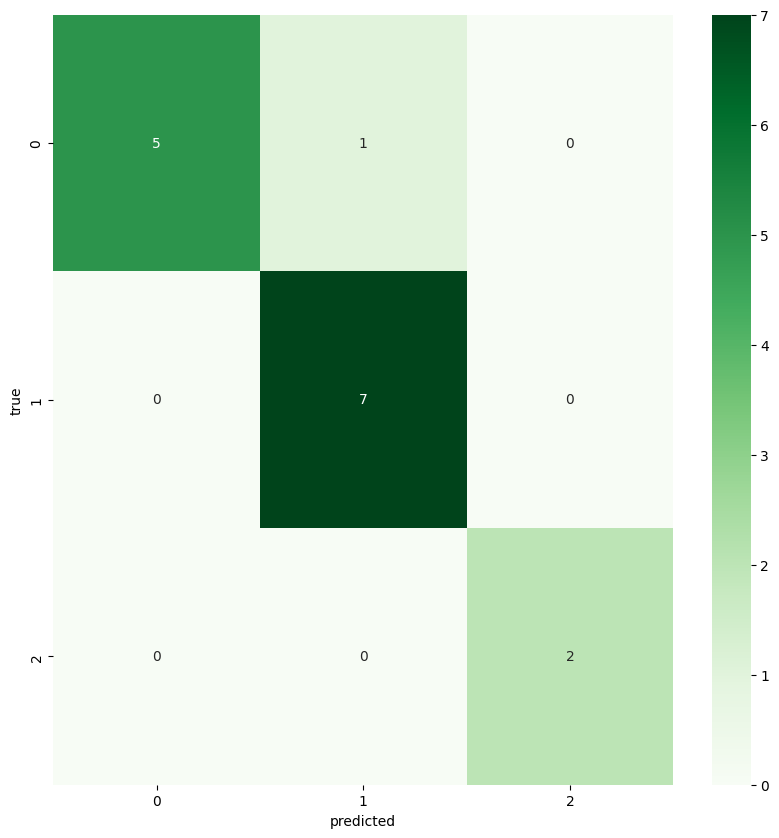

tensor([0, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 2, 0, 1, 1])
0.9333333333333333


In [230]:
matrix = confusion_matrix(labels,predicted,labels=np.unique(labels))
plt.figure(figsize=(10,10))
seaborn.heatmap(matrix,annot=True, fmt='d', xticklabels=np.unique(labels),yticklabels=np.unique(labels),cmap="Greens")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

accuracy = accuracy_score(labels, predicted)
print(predicted)
print(accuracy)